In [1]:
library("rwwa")

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula




# Compute SPEI


In [1]:
suppressMessages(library(SPEI))

In [3]:
sapply(c("mswep", "chirps"), function(ds) {
    df = read.csv(paste0("data/", ds, "_ts_monthly.csv"))
    df_ts <- ts(df$pr, start = sapply(strsplit(df$time[1], "-")[[1]], as.integer)[1:2], frequency = 12)
    res_df <- sapply(c(1,3,6,12,24), function(nm) {
        spi_m <- spi(df_ts, scale = nm, ref.start = c(1990,1), ref.end = c(2020,12))
        spi_m$fitted
    })
    write.csv(setNames(data.frame(df$time, res_df), c("time", "spi_1", "spi_3", "spi_6", "spi_12", "spi_24")), file = paste0("data/",ds,"_spi-monthly.csv"), row.names = F)
})

$mswep
NULL

$chirps
NULL

---
# Fitted models

## Wet-season precipitation

In [20]:
chirps <- load_ts("ts/panama_pr-wetseason_chirps.dat", col.names = c("year", "pr"))
mswep <- load_ts("ts/panama_pr-wetseason_mswep.dat", col.names = c("year", "pr"))

In [21]:
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))

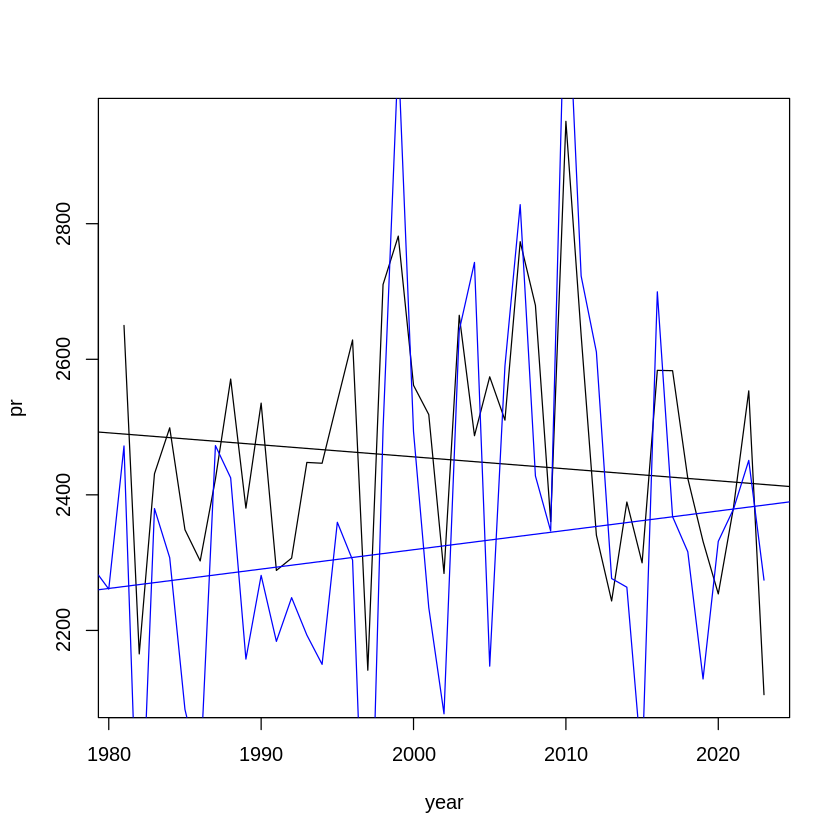

In [26]:
plot(chirps, type = "l")
abline(line(chirps$year, chirps$pr))

lines(mswep, col = "blue")
abline(line(mswep$year, mswep$pr), col = "blue")


In [23]:
ablineline(chirps$year, chirps$pr)


Call:
line(chirps$year, chirps$pr)

Coefficients:
[1]  5997.693    -1.771


## Dry-season precipitation

In [27]:
chirps <- load_ts("ts/panama_pr-dryseason_chirps.dat", col.names = c("year", "pr"))
mswep <- load_ts("ts/panama_pr-dryseason_mswep.dat", col.names = c("year", "pr"))

In [28]:
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))

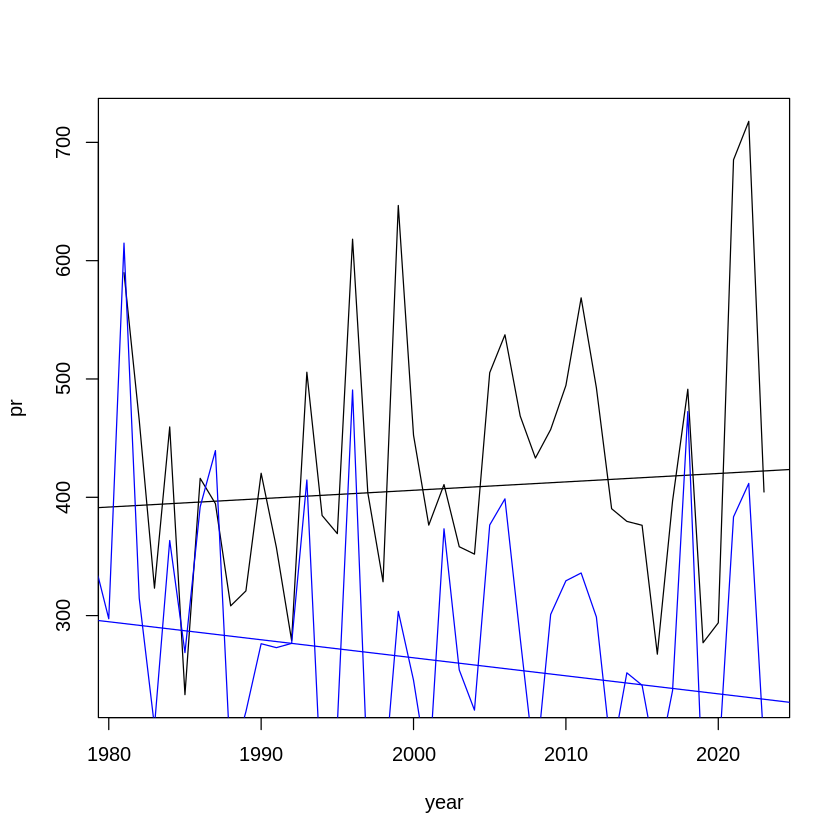

In [29]:
plot(chirps, type = "l")
abline(line(chirps$year, chirps$pr))

lines(mswep, col = "blue")
abline(line(mswep$year, mswep$pr), col = "blue")


# Nino vs SST as covariate

In [81]:
# create DF of all covariate candidates
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

atl <- read.csv("ts/panama_atlanticsst-rs.csv", col.names = c("year", "atlantic"))
df <- merge(merge(gmst, atl), nino)

# remove GMST trend from Atlantic ocean temperatures
df$atl_anom <- resid(lm(atlantic ~ gmst, df))

# add predictand
df <- merge(df, load_ts("ts/panama_pr-wetseason_acp-long.dat", col.names = c("year", "pr")))

cov_f <- df[df$year == 2023,c("gmst", "nino", "atlantic", "atl_anom"),drop = F]
rownames(cov_f) <- ""

cov_cf <- rbind("pi" = cov_f - c(1.2,0,0,0),
                "neut" = c(0,0,unlist(cov_f[,3:4])),
                "atl_anom" = c(0,unlist(cov_f[,2:3]),0))

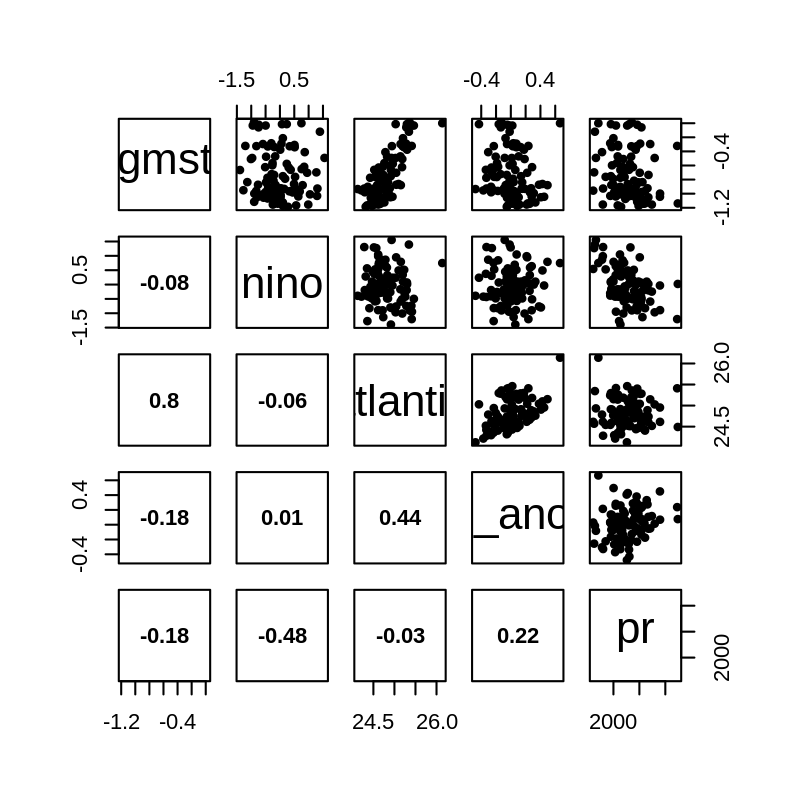

In [112]:
prep_window(c(1,1))
pairs(df[,c("gmst", "nino", "atlantic", "atl_anom", "pr")], lower.panel = panel.cor)

# slight positive 

In [42]:
models <- list("gmst + atl_anom" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "atl_anom"), lower = T),
               "gmst + nino" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T),
               "gmst + nino + atl_anom" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino", "atl_anom"), lower = T),
               "gmst" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst"), lower = T),
               "atlantic" = fit_ns("norm", "fixeddisp", df, "pr", c("atlantic"), lower = T),
               "gmst + atlantic" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "atlantic"), lower = T))

In [43]:
sapply(models, aic, simplify = F)

$`gmst + atl_anom`
[1] 1418.993

$`gmst + nino`
[1] 1393.134

$`gmst + nino + atl_anom`
[1] 1389.615

$gmst
[1] 1421.683

$atlantic
[1] 1424.413

$`gmst + atlantic`
[1] 1423.824

In [63]:
prep_window(c(1,2), w = 7)

plot_trend(models[["gmst + nino + atl_anom"]], main = "gmst + nino + atl_anom")
plot_trend(models[["gmst + nino"]], main = "gmst + nino + atl_anom")

In [62]:
# compare residuals
resid <- sapply(models, function(mdl) mdl$x - ns_pars(mdl)$loc)
                

prep_window(c(1,1))

plot(density(resid[,"gmst + nino"]))
rug(resid[,"gmst + nino"])
lines(density(resid[,"gmst + nino + atl_anom"]), col = "red")
rug(resid[,"gmst + nino + atl_anom"], col = "red")

In [106]:
res <- sapply(models, mdl_ests, cov_f = cov_f, cov_cf = cov_cf)
res <- rbind.fill(sapply(sapply(sapply(res, data.frame, simplify = F), t), data.frame))
rownames(res) <- names(models)

In [110]:
# so the warm Atlantic anomaly should actually be making it wetter...
res[,c("dI_abs_pi", "dI_abs_neut", "dI_abs_atl_anom")]

,dI_abs_pi,dI_abs_neut,dI_abs_atl_anom
,<dbl>,<dbl>,<dbl>
gmst + atl_anom,-103.6538,0.0000,128.3364
gmst + nino,-196.9829,-152.1696,0.0000
gmst + nino + atl_anom,-168.6642,-151.9491,136.3775
gmst,-140.7432,0.0000,0.0000
atlantic,0.0000,0.0000,0.0000
gmst + atlantic,-117.3718,0.0000,0.0000


In [111]:
res[,c("PR_pi", "PR_neut", "PR_atl_anom")]

,PR_pi,PR_neut,PR_atl_anom
,<dbl>,<dbl>,<dbl>
gmst + atl_anom,2.216377,1.000000,0.3739858
gmst + nino,4.248066,3.008432,1.0000000
gmst + nino + atl_anom,4.560193,3.912922,0.3225383
gmst,2.603576,1.000000,1.0000000
atlantic,1.000000,1.000000,1.0000000
gmst + atlantic,2.223565,1.000000,1.0000000


In [114]:
boot_res <- boot_ci(models[["gmst + nino + atl_anom"]], cov_f = cov_f, cov_cf = cov_cf)

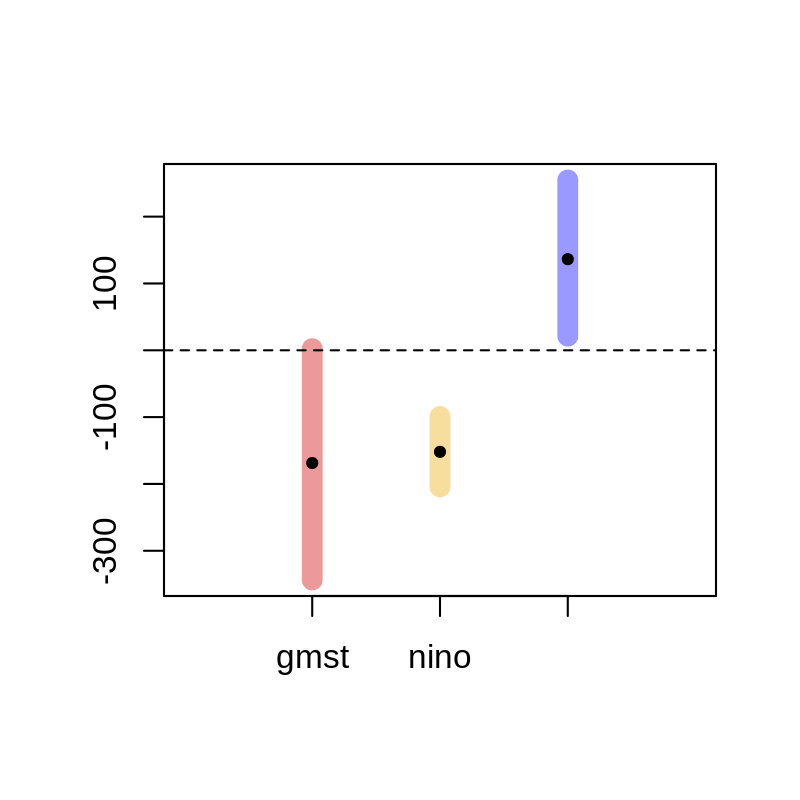

In [131]:
abs_di <- boot_res[grepl("dI_abs", rownames(boot_res)),]

plot(0, type = "n", xlim = c(0,4), ylim = range(abs_di), xlab = "", ylab = "", xaxt = "n")
segments(x0 = 1:3, y0 = abs_di[,"2.5%"], y1 = abs_di[,"97.5%"], lwd = 10, col = adjustcolor(c("red3", "darkgoldenrod2", "blue"), 0.4))
points(1:3, abs_di[,"est"], pch = 20)
abline(h = 0, lty = 2)
axis(1, at = 1:3, labels = c("gmst", "nino", "atlantic anomaly"))

# Model monthly precip instead?

Needs more sophisticated modelling to incorporate seasonal cycle - currently not implemented in rwwa

In [105]:
# load monthly data
df <- merge(read.csv("data/monthly_nino34.csv", col.names = c("date", "nino")),
            read.csv("data/monthly_pr-acp1925.csv", col.names = c("date", "pr")))

# merge with annual GMST (should be fine for initial analysis)
df$year <- as.integer(substr(df$date, 1, 4))
df <- merge(df, read.table("ts/gmst.dat", col.names = c("year", "gmst")))

df$month <- as.integer(substr(df$date,6,7))

In [106]:
# also reconstruct annual data to compare the two models
df_ann <- merge(read.table("ts/gmst.dat", col.names = c("year", "gmst")), 
                data.frame(year = 1925:2023,
                           "nino" = filter(df$nino, rep(1/8,8), sides = 1)[substr(df$date,6,7) == "12"],
                           "pr" = filter(df$pr, rep(1,8), sides = 1)[substr(df$date,6,7) == "12"]))

In [121]:
mdl_monthly <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
mdl_ann <- fit_ns("norm", "fixeddisp", df_ann, "pr", c("gmst", "nino"), lower = T)

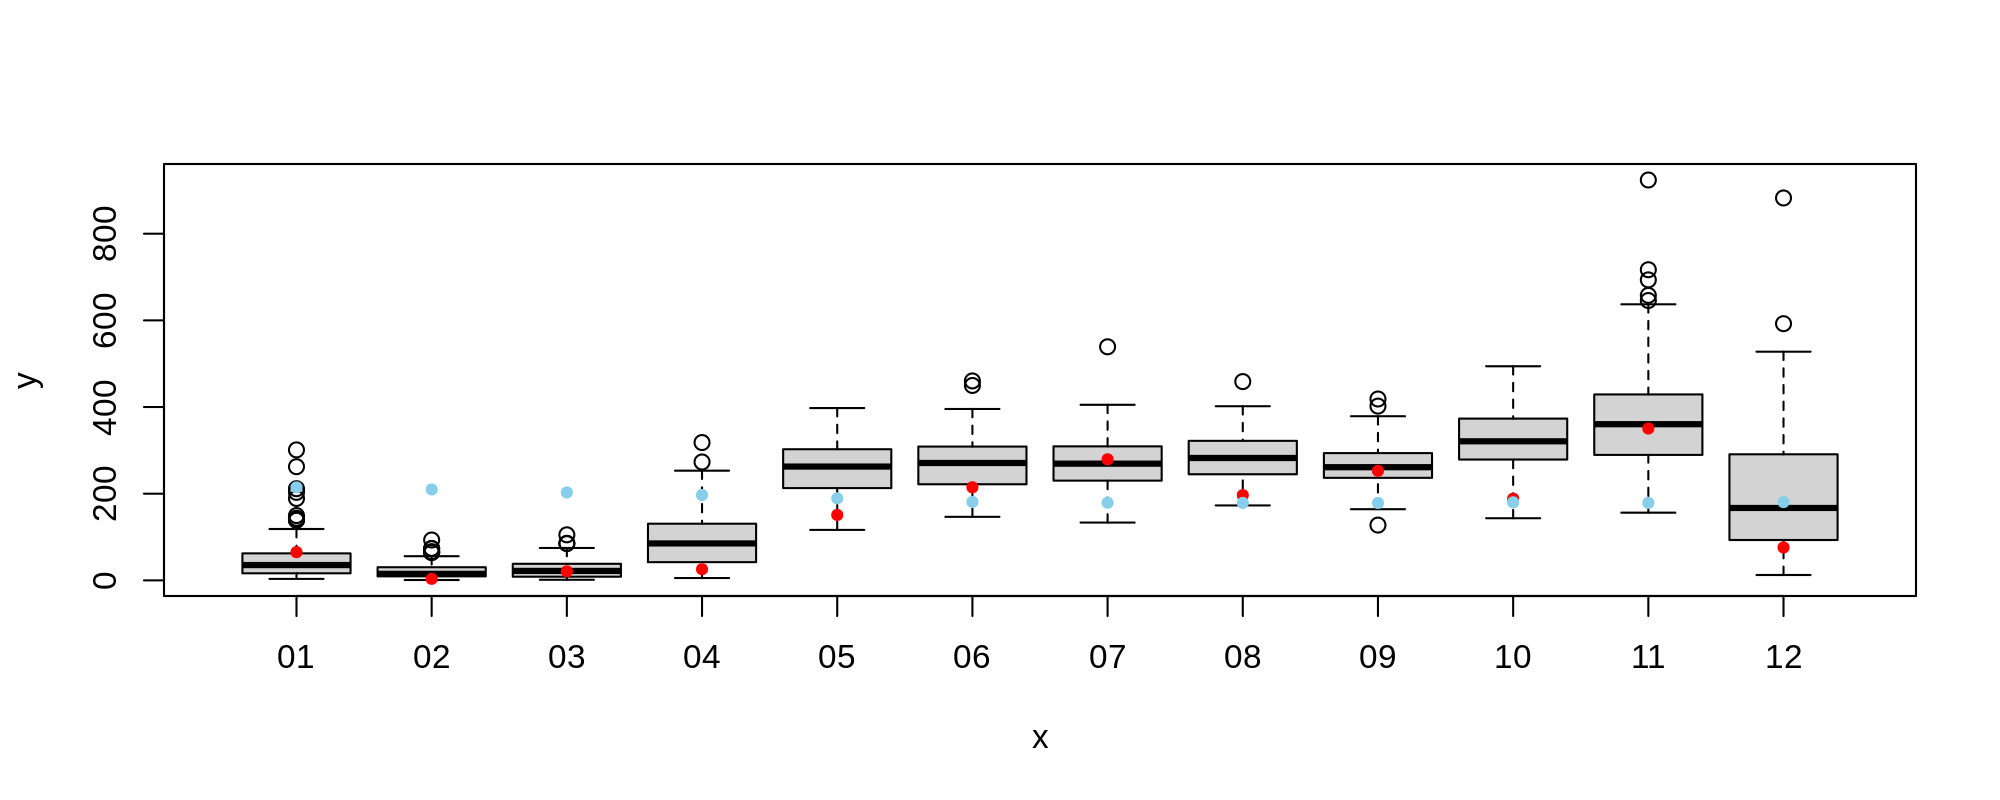

In [122]:
plot(df$month, df$pr)
points(df[df$year == 2023, c("month", "pr")], col = "red", pch = 20)

points(1:12, ns_pars(mdl_monthly)$loc[df$year == 2023], pch = 20, col = "skyblue")

In [97]:
res_monthly <- data.frame(year = 1925:2023,
                          "pr" = filter(df$pr, rep(1,8), sides = 1)[substr(df$date,6,7) == "12"],
                          "fitted_m" = filter(ns_pars(mdl_monthly)$loc, rep(1,8), sides = 1)[substr(df$date,6,7) == "12"],
                          "rp6_m" = filter(eff_return_level(mdl_monthly, 6), rep(1,8), sides = 1)[substr(df$date,6,7) == "12"],
                          "rp40_m" = filter(eff_return_level(mdl_monthly, 40), rep(1,8), sides = 1)[substr(df$date,6,7) == "12"])

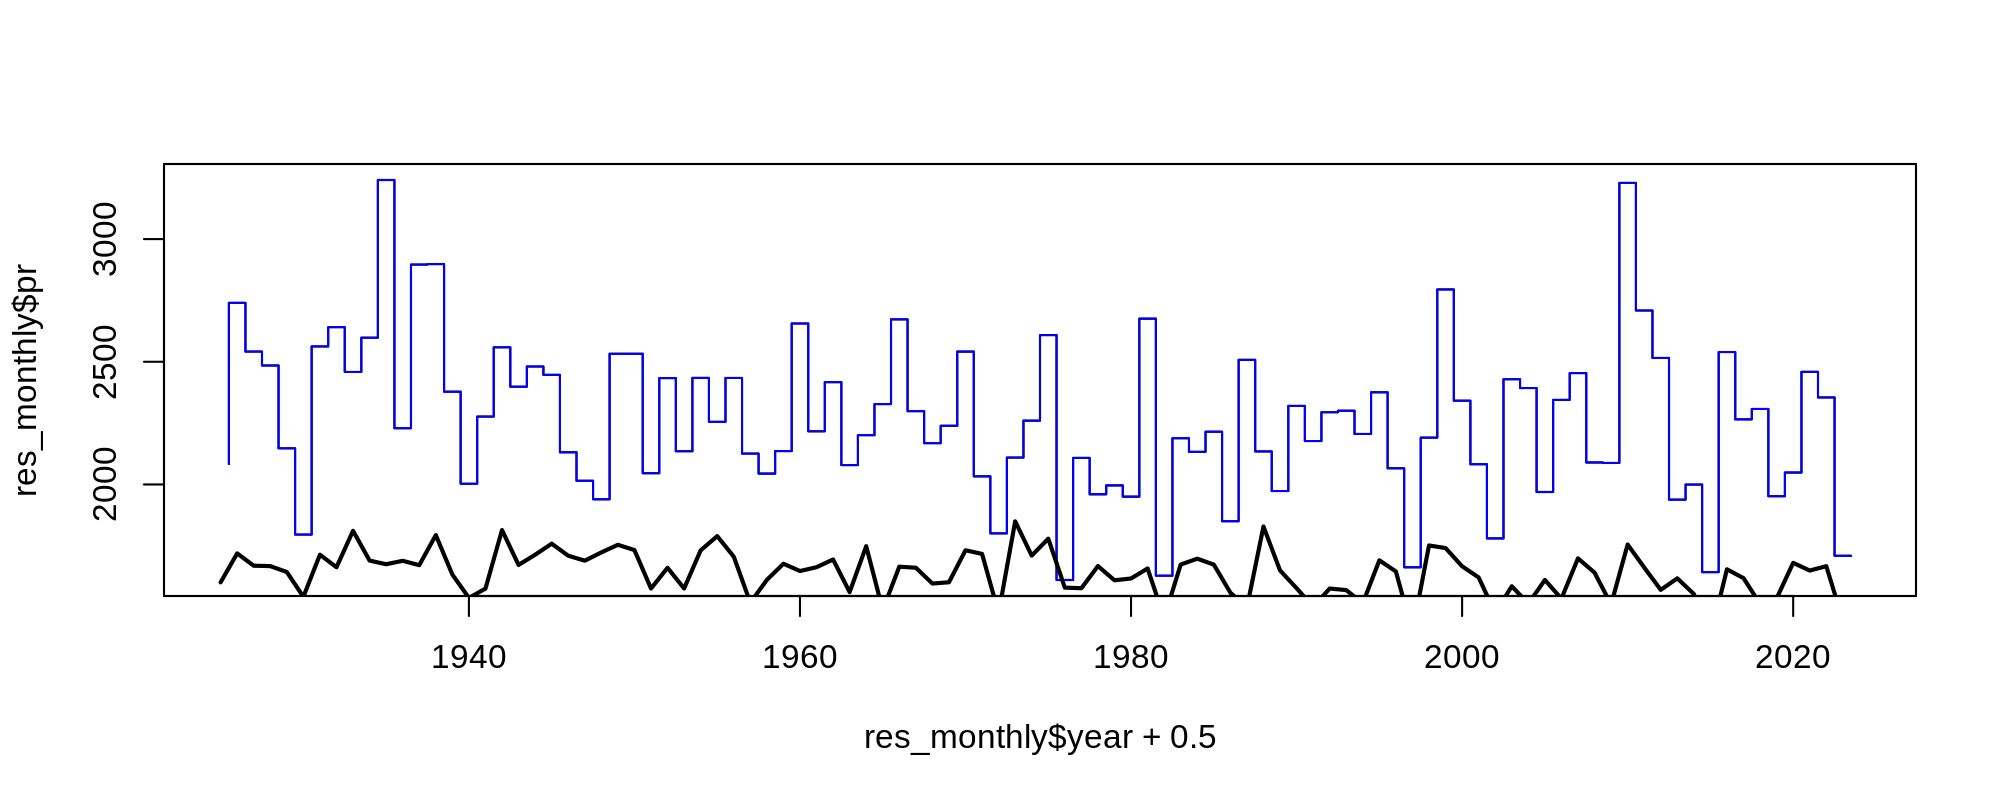

In [98]:
plot(res_monthly$year + 0.5, res_monthly$pr, type = "S")
lines(df_ann$year+0.5, df_ann$pr, col = "blue", type = "S") # precip is the same
lines(res_monthly$year, res_monthly$fitted_m, lwd = 2)

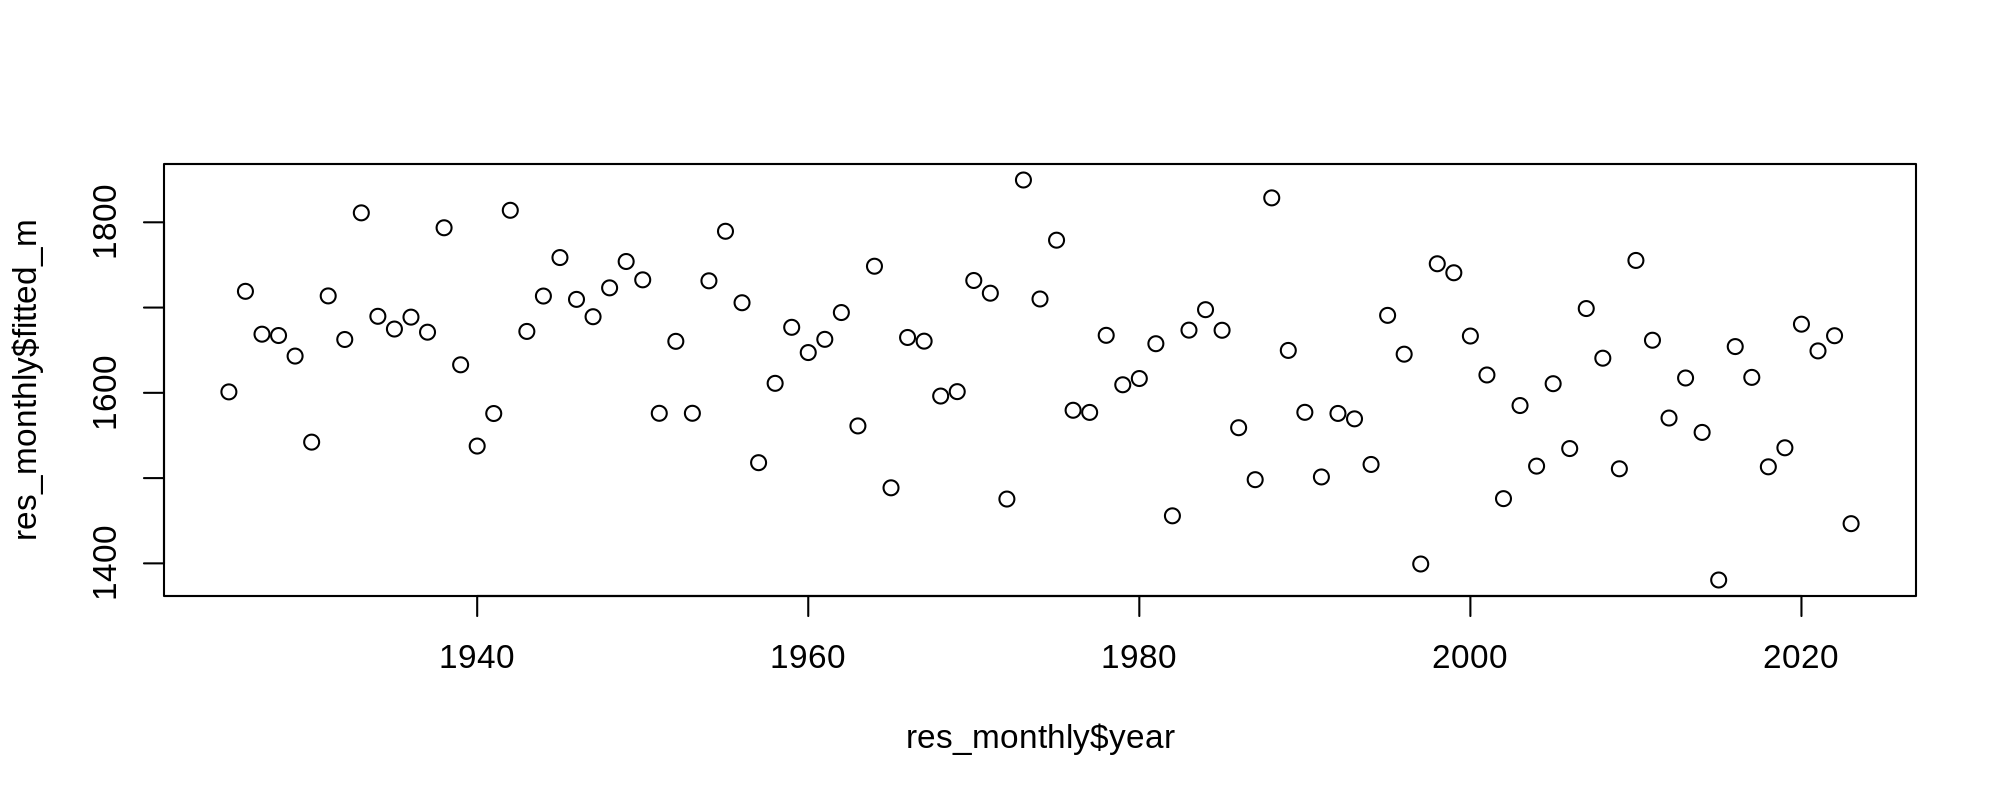

In [86]:

plot(res_monthly$year, res_monthly$fitted_m)

In [ ]:
agg <- merge(setNames(aggregate(df$pr, by = list("year" = df$year), "sum"), c("year", "pr")),
                setNames(aggregate(ns_pars(mdl_monthly)$loc, by = list("year" = df$year), "sum"), c("year", "fitted")))

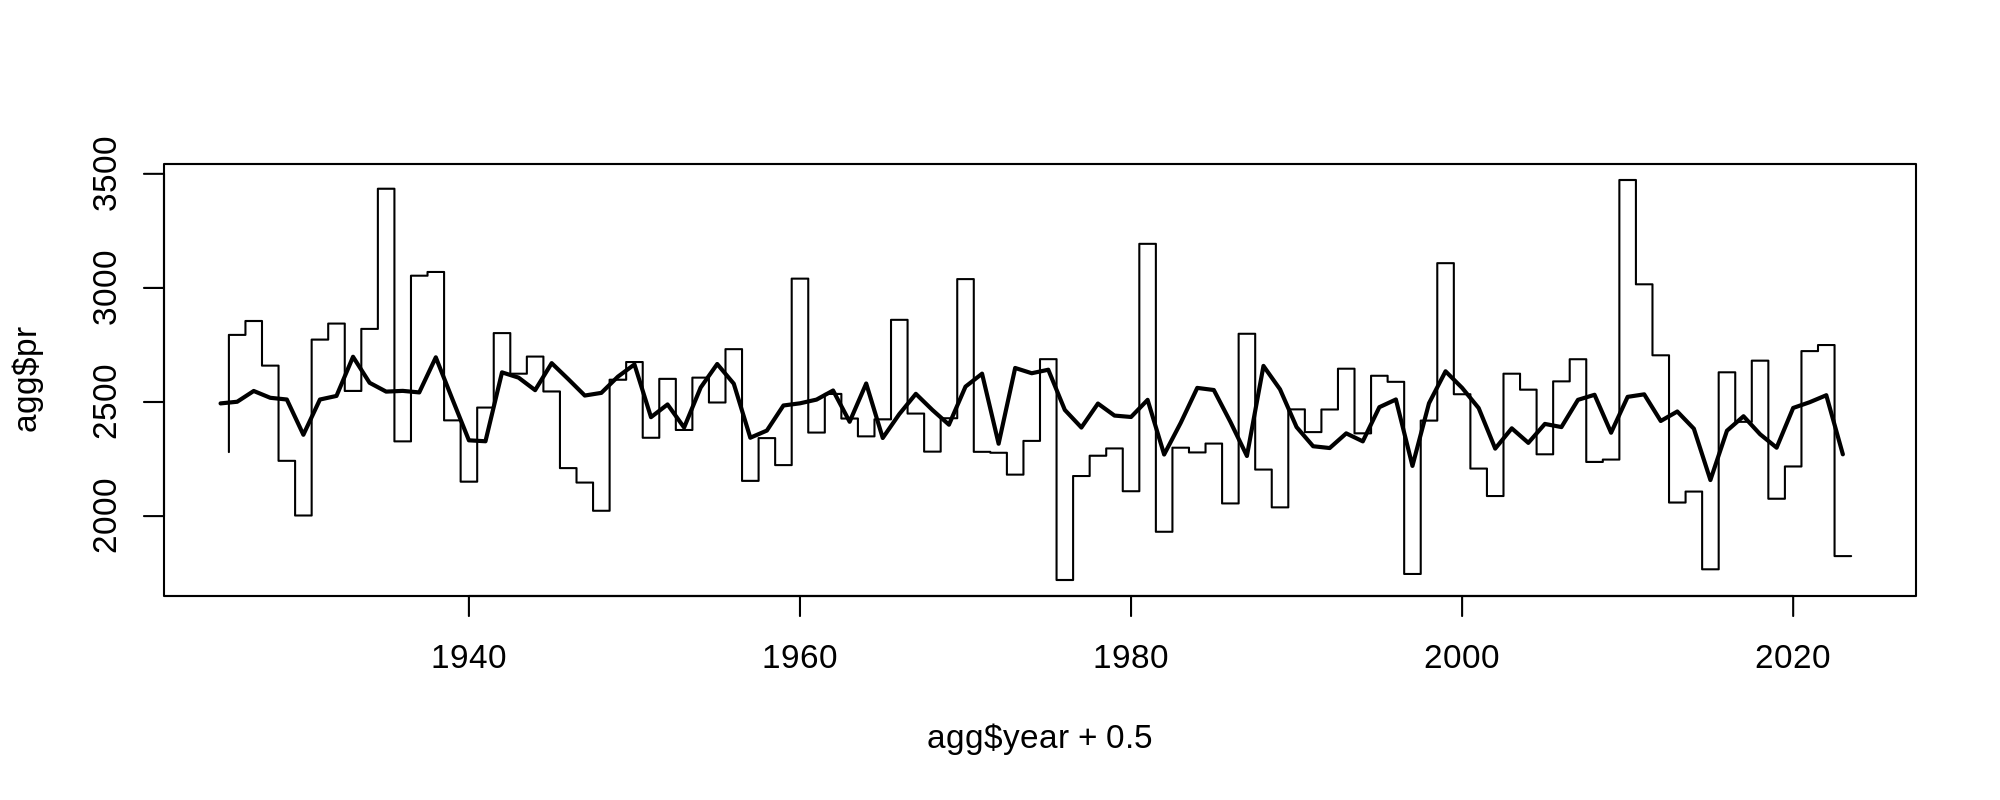

In [ ]:
plot(agg$year+0.5, agg$pr, type = "S")
lines(agg$year, agg$fitted, lwd = 2)

## Monthly with month as factor

_Not implemented for Clausius Clapeyron model - but pretty linear over this period so may not be a problem (if it is, will use logged data)_

In [2]:
# load monthly data
df <- merge(read.csv("data/monthly_nino34.csv", col.names = c("date", "nino")),
            read.csv("data/monthly_pr-acp1925.csv", col.names = c("date", "pr")))

# merge with annual GMST (should be fine for initial analysis)
df$year <- as.integer(substr(df$date, 1, 4))
df <- merge(df, read.table("ts/gmst.dat", col.names = c("year", "gmst")))

df$month <- as.factor(substr(df$date,6,7))

In [3]:
# fit linear model & look at predicted vs observed values
lmodel <- lm(pr ~ month + nino + gmst, df)
rs_fitted <- filter(fitted(lmodel), rep(1,8), sides = 1)[substr(df$date,6,7) == "12"]

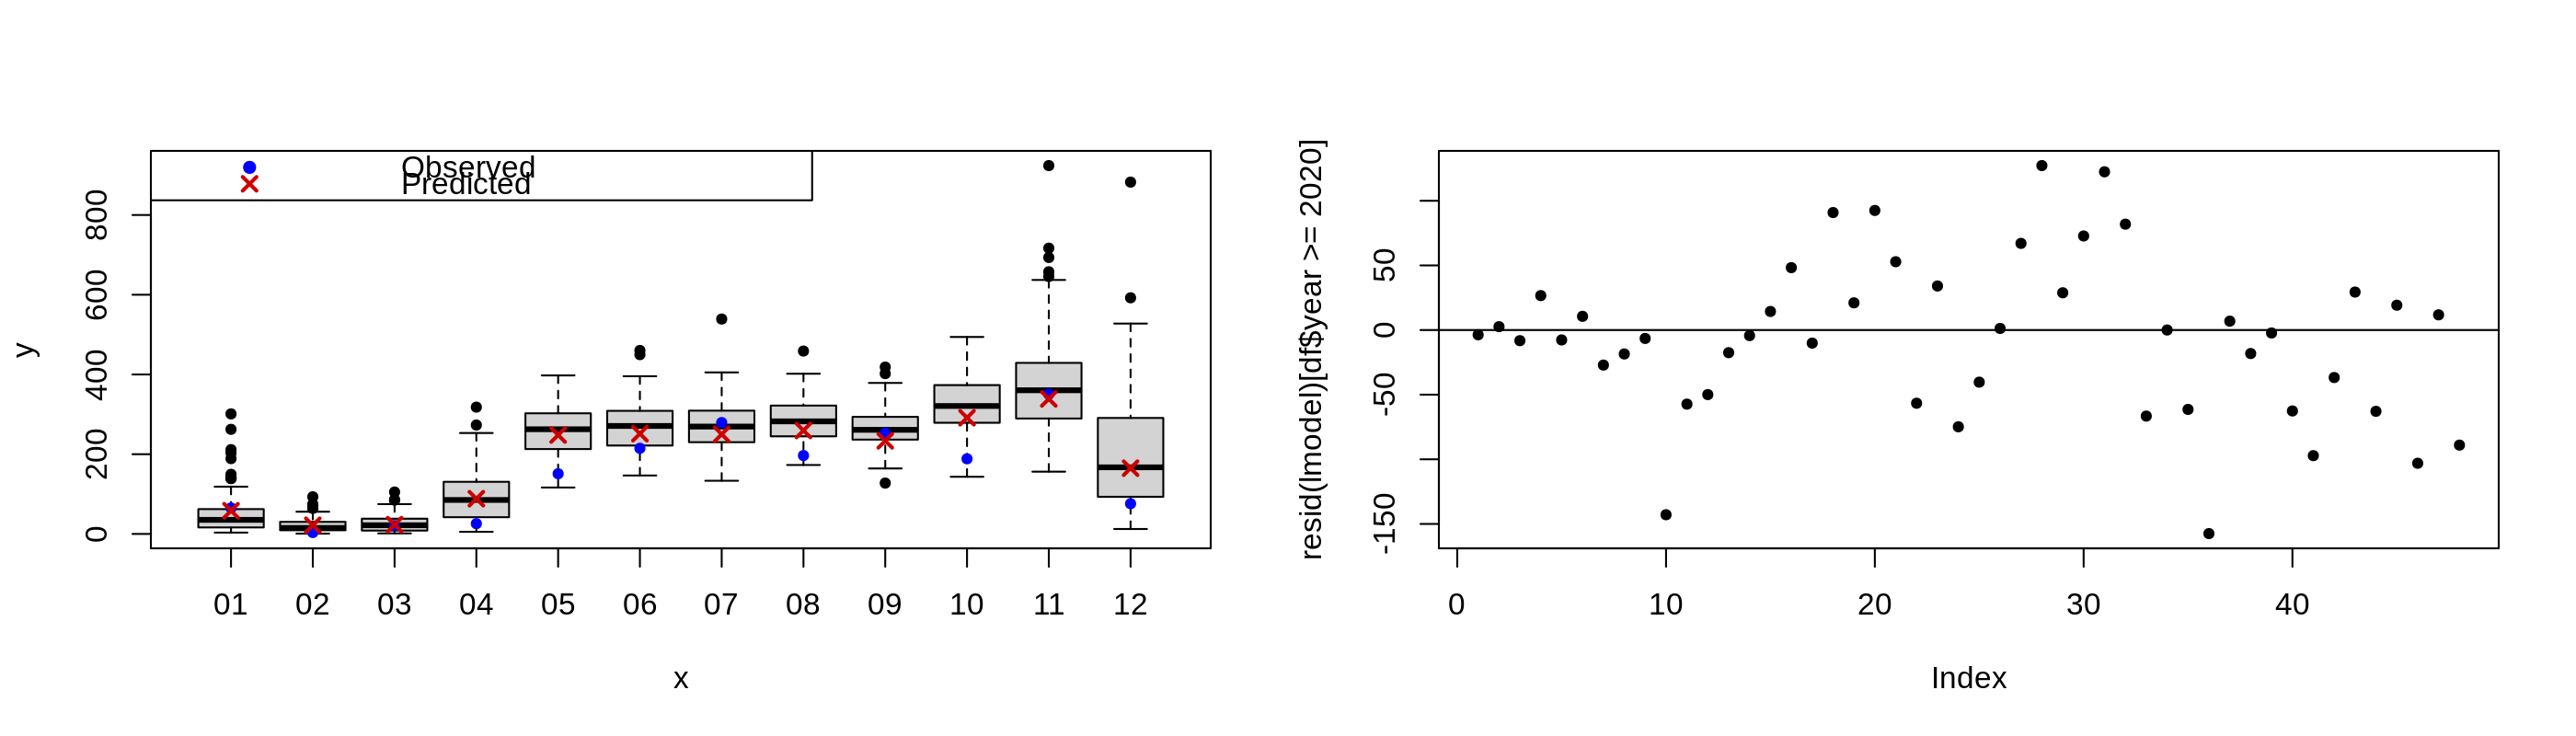

In [4]:
prep_window(c(1,2), w = 7)

plot(df$month, df$pr)
points(df[df$year == 2023, c("month", "pr")], col = "blue", pch = 20)

points(1:12, fitted(lmodel)[df$year == 2023], pch = 4, lwd = 2, col = "red3")
legend("topleft", c("Observed", "Predicted"), col = c("blue", "red3"), pch = c(20,4), lwd = 2, lty = NA)

# still not as low as it should be, but better

plot(resid(lmodel)[df$year >= 2020])
abline(h = 0)

In [5]:
# also reconstruct annual data to compare the two models
df_ann <- merge(read.table("ts/gmst.dat", col.names = c("year", "gmst")), 
                data.frame(year = 1925:2023,
                           "nino" = filter(df$nino, rep(1/8,8), sides = 1)[substr(df$date,6,7) == "12"],
                           "pr" = filter(df$pr, rep(1,8), sides = 1)[substr(df$date,6,7) == "12"]))

mdl_ann <- fit_ns("norm", "fixeddisp", df_ann, "pr", c("gmst", "nino"), lower = T)

In [25]:
# compare RMSE
sqrt(mean((df_ann$pr - ns_pars(mdl_ann)$loc)^2))    # fit to rainy season
sqrt(mean((df_ann$pr - rs_fitted)^2))               # fit to individual months (although NB this was a linear fit rather than exponential)

cat("\n")

# compare MAE
mean(abs(df_ann$pr - ns_pars(mdl_ann)$loc))
mean(abs(df_ann$pr - rs_fitted))

[1] 267.4721

[1] 269.9905

[1] 213.7007

[1] 217.6551

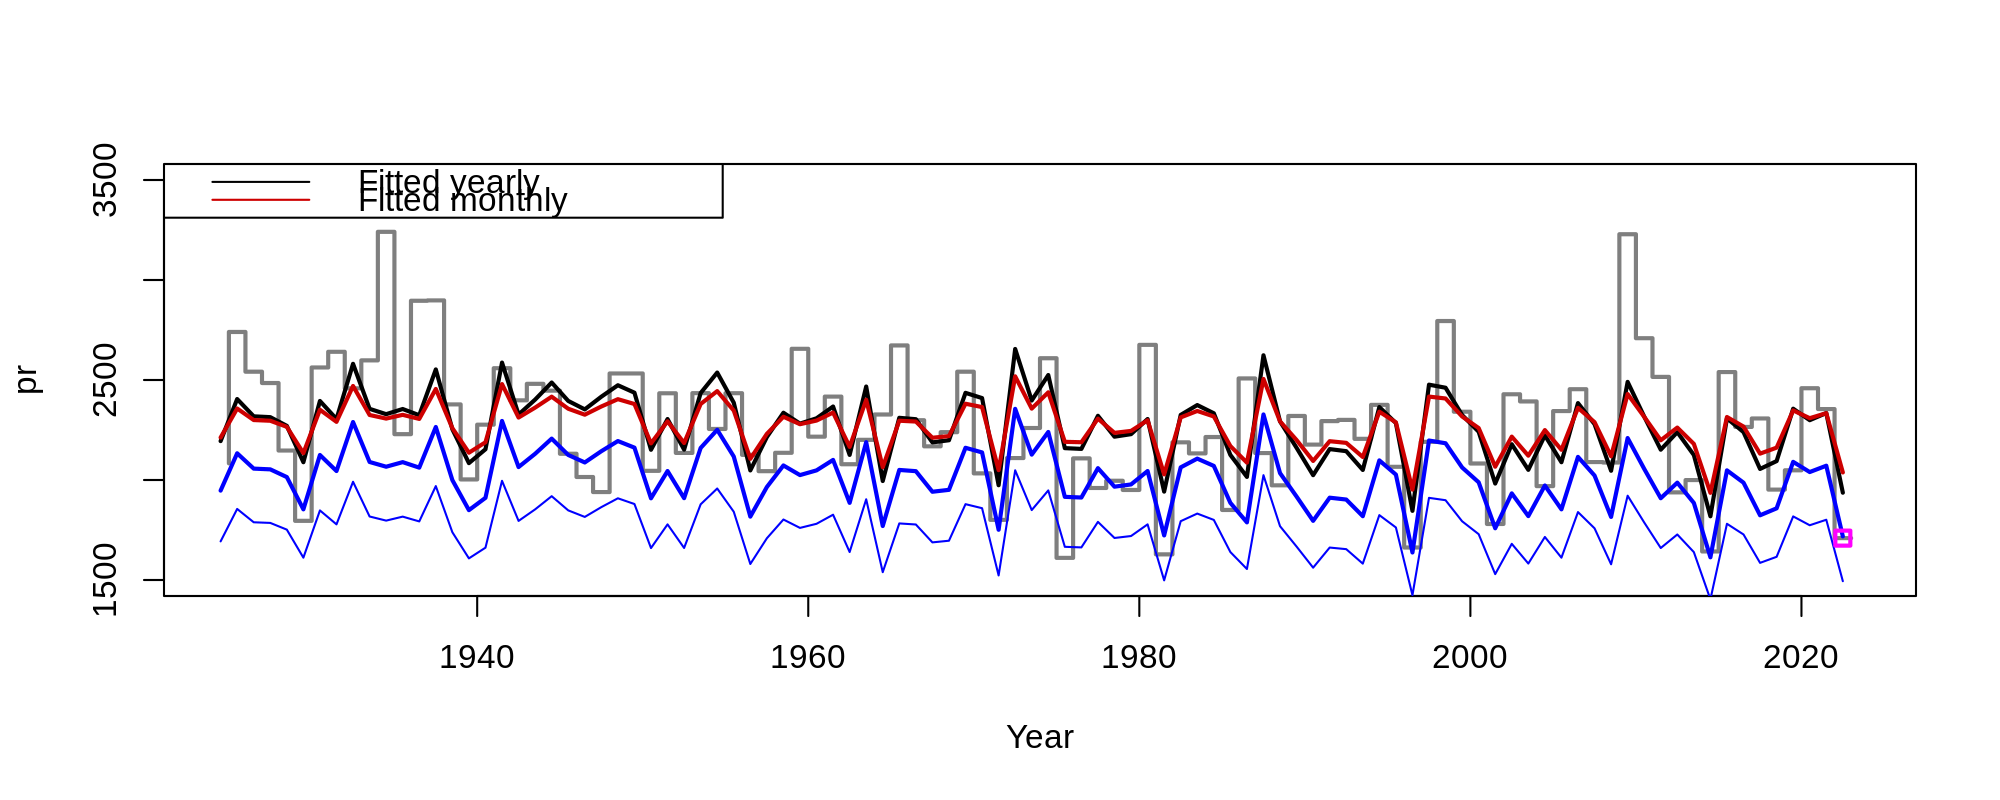

In [18]:
prep_window(w = 10)
plot_trend(mdl_ann, legend_pos = NA)
lines(df_ann$year-0.5, rs_fitted, lwd = 2, col = "red3")

legend("topleft", c("Fitted yearly", "Fitted monthly"), col = c("black", "red3"), lty = 1)